In [1]:
import time
from epics import PV
import numpy as np
import matplotlib.pyplot as plt
import pymodels as pm
import pyaccel as pa
import re

from apsuite.orbcorr.calc_orbcorr_mat import OrbRespmat
from scipy.optimize import minimize
from siriuspy.search import PSSearch
from siriuspy.devices import SOFB
from mathphys.functions import save_pickle, load_pickle

# Experiment

In [183]:
def meas_corr_resp(data, corr_type, corr_idx, curr_delta=0.05):
    if corr_type == 'fch':
        corr_names = fch_names
        curr_sp = fch_curr_sp
        curr_rb = fch_curr_rb
    else:
        corr_names = fcv_names
        curr_sp = fcv_curr_sp
        curr_rb = fcv_curr_rb
    
    psname = corr_names[corr_idx]
    pv_sp = curr_sp[psname]
    pv_rb = curr_rb[psname]
    print(psname)
    
    datum = dict()
    datum['timestamp'] = time.time()
    datum['curr_delta'] = curr_delta
    datum['sofb_nr_points'] = sofb.nr_points
    
    value = pv_sp.value
    
    print('acquire orbit0: curr - delta/2 ... ', end='')
    pv_sp.value = value - curr_delta/2 
    time.sleep(0.2)
    datum['curr0'] = pv_rb.value
    sofb.cmd_reset()
    sofb.wait_buffer()  # wait for buffer to fill
    datum['orbx0'] = sofb.orbx
    datum['orby0'] = sofb.orby
    print(pv_sp.value, datum['curr0'])
    
    print('acquire orbit1: curr + delta/2 ... ', end='')
    pv_sp.value = value + curr_delta/2
    time.sleep(0.2)
    datum['curr1'] = pv_rb.value
    sofb.cmd_reset()
    sofb.wait_buffer()  # wait for buffer to fill
    datum['orbx1'] = sofb.orbx
    datum['orby1'] = sofb.orby
    print(pv_sp.value, datum['curr1'])
    
    print('restore corrector ... ', end='')
    pv_sp.value = value
    time.sleep(0.2)
    datum['curr_final'] = pv_rb.value
    print(pv_sp.value, datum['curr_final'])

    data[psname] = datum
    return psname

In [184]:
def plot_corr_respm(data, corr_type, corr_idx, model_kick=10):
    if corr_type == 'fch':
        corr_names = fch_names
        curr_sp = fch_curr_sp
        cod_model = mat_orbx[:, corr_idx]
    else:
        corr_names = fcv_names
        curr_sp = fcv_curr_sp
        cod_model = mat_orby[:, corr_idx]
    psname = corr_names[corr_idx]
    
    datum = data[psname]
    cod_x = datum['orbx1'] - datum['orbx0']
    cod_y = datum['orby1'] - datum['orby0']
    cod = np.hstack((cod_x, cod_y))

    model_rescale = model_kick / 10.0
    
    plt.plot(1e6*cod_model*model_rescale, '-o', label=f'model ({model_kick} urad)')
    plt.plot(cod, '-o', label='measurement')
    plt.xlabel('BPM index')
    plt.ylabel('COD [um]')
    plt.title(psname)
    plt.legend()
    plt.show()

In [185]:
fch_names = PSSearch.get_psnames({'dev':'FCH'})
fcv_names = PSSearch.get_psnames({'dev':'FCV'})
data = load_pickle('fast-corrs-model-cod-signatures.pickle')
mat_orbx = data['respmx']
mat_orby = data['respmy']

FileNotFoundError: [Errno 2] No such file or directory: 'fast-corrs-model-cod-signatures.pickle'

In [ ]:
sofb = SOFB(SOFB.DEVICES.SI)

fch_curr_sp = {name: PV(name + ':Current-SP') for name in fch_names}
fcv_curr_sp = {name: PV(name + ':Current-SP') for name in fcv_names}
fch_curr_rb = {name: PV(name + ':Current-RB') for name in fch_names}
fcv_curr_rb = {name: PV(name + ':Current-RB') for name in fcv_names}

In [ ]:
print('SOFB connected: ', sofb.connected)
for fch, fcv in zip(fch_names, fcv_names):
    pv_h, pv_v = fch_curr_sp[fch], fcv_curr_sp[fcv]
    pv_h_rb, pv_v_rb = fch_curr_rb[fch], fcv_curr_rb[fcv]
    print(fch, fcv, ' connected: ', pv_h.connected, pv_v.connected, pv_h_rb.connected, pv_v_rb.connected)

In [ ]:
sofb.cmd_change_opmode_to_sloworb()
sofb.nr_points = 30

In [ ]:
data=dict()
data['fch_names'] = fch_names
data['fcv_names'] = fcv_names

In [ ]:
corr_idx, corr_type = 70, 'fcv'

curr_delta = 0.100  # [A]

meas_corr_resp(data, corr_type, corr_idx, curr_delta=curr_delta)

save_pickle(data, 'fast-corr-cod-signature-meas', True)

plot_corr_respm(data, corr_type, corr_idx, model_kick=4)

In [ ]:
plot_corr_respm(data, corr_type, corr_idx, model_kick=4)

# Analysis

## Defining functions

In [2]:
def generate_model_orm():
    mod = pm.si.create_accelerator()
    fam = pm.si.get_family_data(mod)
    orbmat = OrbRespmat(mod, acc='SI', dim='4d')
    orbmat.ch_idx = np.array(fam['FCH']['index']).ravel()
    orbmat.cv_idx = np.array(fam['FCV']['index']).ravel()
    respmat_fofb = orbmat.get_respm()
    return respmat_fofb[:, :-1]

def compute_dorb(data):
    """"Return delta orbit matrice."""
    fch_names = data['fch_names']
    fcv_names = data['fcv_names']
    fc_names = fch_names + fcv_names
    n = len(fc_names)
    dorb_mat = np.zeros([320, n])
    for j, fc_name in enumerate(fc_names):
        dat = data[fc_name]
        dcurr = dat['curr_delta']
        dorbx = (dat['orbx1'] - dat['orbx0'])
        dorby = (dat['orby1'] - dat['orby0'])
        dorb  = np.hstack([dorbx, dorby])
        dorb_mat[:, j] = dorb

    return dorb_mat

def adjust_measures(data, current=0.1):
    mod_orm = generate_model_orm()
    dorb = compute_dorb(data)
    
    alphax, alphay = compute_alpha(dorb, mod_orm, dimension = 'H')
    fch_gain, fch_angle = compute_gain_and_angle(alphax, alphay, dimension='H')
    
    alphax, alphay = compute_alpha(dorb, mod_orm, dimension = 'V')
    fcv_gain, fcv_angle = compute_gain_and_angle(alphax, alphay, dimension='V')
    
    #              |xx  yx|
    # ORM MATRIX = |      |
    #              |xy  yy|
    # gain = kick = curr2kick*current [urad/A] 
    # curr2kick = gain/current
    
    xx = dorb[:160, :80]
    xx = (1/fch_gain) * np.cos(fch_angle) * xx

    xy = dorb[160:, :80]
    xy = -(1/fch_gain) * np.sin(fch_angle) * xy
    
    yx= dorb[:160, 80:]
    yx = (1/fcv_gain) * np.sin(fcv_angle) * yx 
    
    yy = dorb[160:, 80:]
    yy = (1/fcv_gain) * np.cos(fcv_angle) * yy
    
    xxyx = np.hstack([xx, yx])
    xyyy = np.hstack([xy, yy])
    adj_dorb = np.vstack([xxyx, xyyy])
    
    curr2kick = np.vstack([fch_gain, fcv_gain])/current
    angles = np.vstack([fch_angle, fcv_angle])
    
    return adj_dorb, curr2kick, angles


def compute_alpha(dorb, mod_orm, dimension = 'H'):
    """."""
    n = 80
    alphax = np.zeros(n)
    alphay = np.zeros(n) 
    
    for j in range(n):
        if dimension == 'H':
            deltax, deltay = dorb[:160, j], dorb[160:, j]
            mx, my = mod_orm[:160, j], mod_orm[160:, j+80]
        else:
            deltax, deltay = dorb[:160, j+80], dorb[160:, j+80]
            mx, my = mod_orm[:160, j], mod_orm[160:, j+80]
        
        alphax[j] = np.dot(deltax, mx)/np.dot(mx, mx)
        alphay[j] = np.dot(deltay, my)/np.dot(my, my)
    return alphax, alphay

def compute_gain_and_angle(alphax, alphay, dimension='H'):
    """."""
    alphax = np.asarray(alphax)
    alphay = np.asarray(alphay)
    
    gain = np.sqrt(alphax**2 + alphay**2)
    
    if dimension=='H':
        angle = np.arctan2(alphay, alphax)
    else:
        angle = np.arctan2(-alphax, alphay)
    
    return gain, angle


def compute_corrcoef(m1, m2):
    n = m1.shape[1]
    corrcoeff = np.zeros(n)
    for j in range(n):
        c1, c2 = m1[:, j], m2[:, j]
        c1 -= c1.mean()
        c2 -= c2.mean()
        corrcoeff[j] = (c1 @ c2)/np.sqrt((c1 @ c1) * (c2 @ c2))
    return corrcoeff


def compare_orb_matrices(meas, mod, corr_type='h'):
    with plt.style.context(['science','notebook']):
        plt.figure(figsize=(12,9))
        if corr_type=='h':
            meas_orb = meas[:160, :80]
            mat_orb = mod[:160, :80]
        else:
            meas_orb = meas[160:, 80:]
            mat_orb = mod[160:, 80:]
        diff_matrix = (meas_orb - mat_orb)
#         print(diff_matrix.shape)
#         return 0
        plt.pcolormesh(diff_matrix, cmap='seismic')
        plt.xlabel(f'FC{corr_type.upper()} idx')
        plt.ylabel('BPM idx')
        plt.xticks(np.arange(0, mat_orb.shape[1], 5))
        plt.title(f'Difference between measured and nominal ORM for FC{corr_type.upper()}', fontsize=16)
        plt.colorbar(label='($ORM_{meas}$ - $ORM_{model}$) [m/rad]')
        plt.savefig(f'orm_fc{corr_type}_diff.png', dpi=300, transparent=False, facecolor='white')


## Comparing ORM matrices

In [3]:
data = load_pickle('fast-corr-cod-signature-meas.pickle')
dorb = compute_dorb(data)
orm = generate_model_orm()

In [4]:
adj_dorb, curr2kick, angles = adjust_measures(data)

In [160]:
# Excluding sector 3
adj_dorb[:, 7:11] = 0
adj_dorb[:, 87:91] = 0

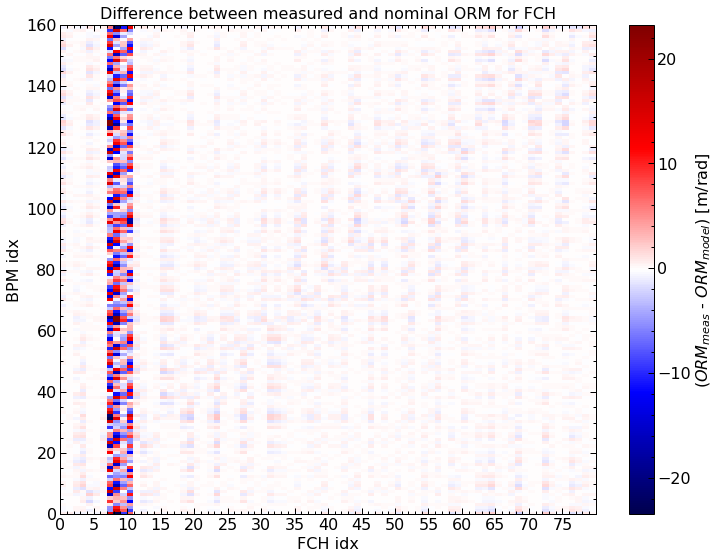

In [161]:
compare_orb_matrices(adj_dorb, orm, 'h')

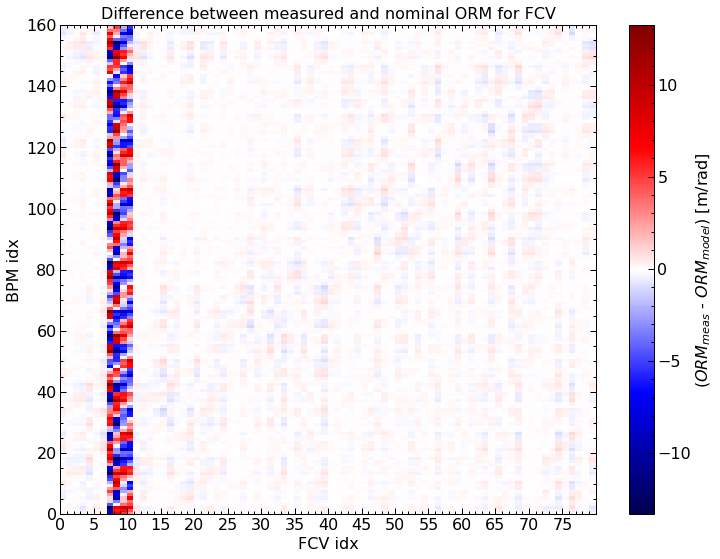

In [159]:
compare_orb_matrices(adj_dorb, orm, 'v')

Taking a look in the conversion factor

Text(110, -20, 'FV correctors')

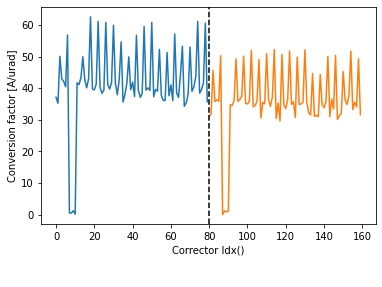

In [5]:
x = np.arange(curr2kick.size)
plt.plot(x[:80], curr2kick[0], c='tab:blue')
plt.plot(x[80:], curr2kick[1], c='tab:orange')
plt.ylabel("Conversion factor [A/urad]")
plt.xlabel('Corrector Idx()')
plt.axvline(80, ls='--', c='k')
plt.annotate('FH correctors', xy=(15, -20))
plt.annotate('FV correctors', xy=(110, -20))

Loking to the angles

In [11]:
# Converting angles to degrees
dangles = angles*180/np.pi
x = np.arange(curr2kick.size)
plt.plot(x[:80], dangles[0], c='tab:blue')
plt.plot(x[80:], dangles[1], c='tab:orange')
plt.ylabel("Rotation angles [º]")
plt.xlabel('Corrector Idx()')
plt.ylim([-15, 15])
plt.axvline(80, ls='--', c='k')
plt.annotate('FH correctors', xy=(15, -10))
plt.annotate('FV correctors', xy=(110, -10))

Text(110, -10, 'FV correctors')

Checking if the last FV corrector is with inverted polarization

In [87]:
fcv_names = data['fcv_names']
plt.plot(orm[:, -1], '-o', label='model', c='tab:blue')
plt.plot(dorb[:, -1]/alphax_h[-1], '-o', label='measured', c='tab:orange')
plt.plot(adj_dorb[:, -1], '-o', label='adj measured', c='tab:green')
plt.title(fcv_names[-1])
plt.ylabel('$\Delta y$')
plt.xlabel('BPM idx')
plt.legend(loc='lower right', bbox_to_anchor = (1.4,0.5))
plt.savefig('fcv_corr_problem', dpi=300, transparent=False, facecolor='white')

## Coupling analysis

Computing correlation coefficient

In [218]:
# First the correlation between the measures and model for FCH
fchx_mod = orm[:160, :80]
fchx_meas = adj_dorb[:160, :80]
fchx_corrcoeff = compute_corrcoef(fchx_mod, fchx_meas)

/home/jucelio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in double_scalars


In [220]:
# Correlation between the measures and model for FCV
fcvy_mod = orm[160:, 80:]
fcvy_meas = adj_dorb[160:, 80:]
fcvy_corrcoeff = compute_corrcoef(fcvy_mod, fcvy_meas)

/home/jucelio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in double_scalars


Computing coupling between correctors

In [237]:
# Trying to find coupling in the measures for FCH
fchy_meas = adj_dorb[160:, :80]
# If we kick with FCH, there is a signature relationated with the kick of FCV?
xy_corrcoeff = compute_corrcoef(fcvy_mod, fchy_meas)
alphayx = dorb[160, :80]

/home/jucelio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in double_scalars


Text(0, 0.5, 'Person correlation')

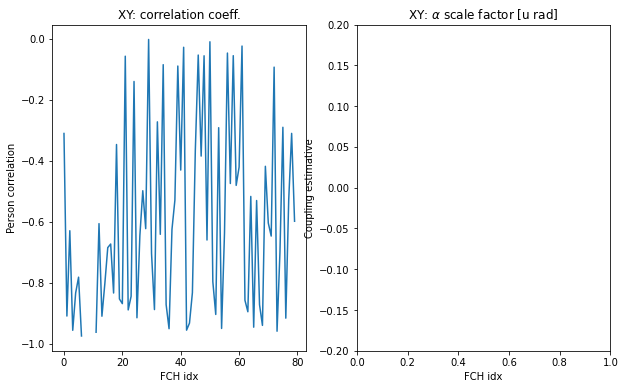

In [239]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].plot(xy_corrcoeff)
ax[0].set_title('XY: correlation coeff.')
# ax[1].plot(alphaxzzy)
ax[1].set_ylim(-0.2, 0.2)
ax[1].set_title(r'XY: $\alpha$ scale factor [u rad]') 
ax[0].set_xlabel('FCH idx')
ax[1].set_xlabel('FCH idx')
ax[1].set_ylabel('Coupling estimative')
ax[0].set_ylabel('Person correlation')

In [240]:
# Trying to find coupling in the measures for FCV
fcvx_meas = orm[:160, 80:]
# If we kick with FCV, there is a signature relationated with the kick of FCH?
yx_corrcoeff = compute_corrcoef(fchx_mod[:, :-1], fcvx_meas)
alphayx = compute_alpha(fcvx_meas, fchx_mod[:, :-1])

/home/jucelio/.local/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in double_scalars


IndexError: index 80 is out of bounds for axis 1 with size 79

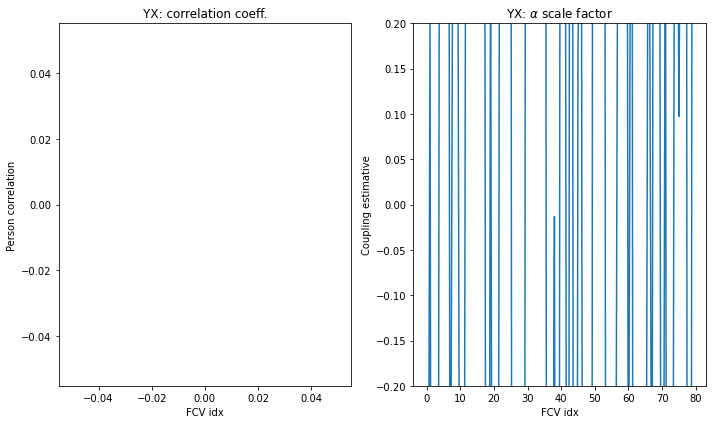

In [241]:
fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].plot(yx_corrcoeff)
ax[0].set_title('YX: correlation coeff.')
ax[0].set_xlabel('FCV idx')
ax[1].set_xlabel('FCV idx')
ax[1].set_ylabel('Coupling estimative')
ax[0].set_ylabel('Person correlation')

ax[1].plot(alphayx)
ax[1].set_ylim(-0.2, 0.2)
ax[1].set_title(r'YX: $\alpha$ scale factor')
plt.tight_layout()

In [200]:
coupled_fch = np.where(xy_corrcoeff > 0.75)[0]
coupled_fcv = np.where(yx_corrcoeff > 0.75)[0]

In [201]:
double_coupled = []
for i in range(0, 80):
    if i in coupled_fch and i in coupled_fcv:
        double_coupled.append(i)

Strong "apparently coupled" correctors 

[3, 4, 17, 19, 22, 35, 36, 51, 52, 54, 65, 67, 68]

## Taking a look in some of the coupled correctors:

In [71]:
fch_names=data['fch_names']
fcv_names=data['fcv_names']

alphax_h, alphay_h = compute_alpha(dorb, orm, dimension='H')
alphax_v, alphay_v = compute_alpha(dorb, orm, dimension='V')

In [81]:
idx = 54
fchy = (1/alphax[idx])*dorb[160:, idx]
fcvy_model = orm[160:, 80+idx]
fchy_adj =adj_dorb[160:, idx]

plt.title(fch_names[idx])
plt.plot(fchy, label='FCH (Vertical kick)', alpha=0.8)
plt.plot(fcvy_model*0.1, label='0.1 * FCV (Vertical Kick)', alpha=0.8)
plt.plot(fchy_adj, label=f'FCH Rot = {dangles[0][idx]:.2f} º. (Vertical Kick)')

plt.xlabel('BPM idx')
plt.ylabel('')
plt.legend()
plt.show()

In [74]:
idx = 22
fchy = (1/alphax[idx])*dorb[160:, idx]
fcvy_model = orm[160:, 80+idx]
fchy_adj = adj_dorb[160:, idx]

plt.title(fch_names[idx])
plt.plot(fchy_adj, label='FCH Rot(Vertical Kick)')
plt.plot(fchy, label='FCH (Vertical kick)')
plt.plot(fcvy_model*0.08, label='0.1 * FCV (Vertical Kick)')
plt.xlabel('BPM idx')
plt.ylabel('')
plt.legend()
plt.show()

## Checking the correlation with indutance and a fitted rotation

In [18]:
# Criando um objeto para armezenar os dados de cada corretora
class FastCorr:
    """."""
    CorrTypes = ("M1", "M2", "C2", "C3")
    
    def __init__(self, dimension='H', sector='01', corr_type='', indutance=0, curr2kick=0, rotation=0, orm_idx=0):
        """."""
        self._dimension = dimension
        self._sector = sector
        self._corr_type = corr_type
        self._indutance = indutance  # [mH]
        self._curr2kick = curr2kick  # [A/mrad]
        self._rotation = rotation
        self._devname = 'SI-'+sector+corr_type+':PS-FC'+dimension
        self._orm_idx = orm_idx
    
    def __str__(self):
        """."""
        return self._devname

Setting indutance

In [20]:

fchlist = []
fcvlist = []

with open ('indutancia.txt', 'rt') as myfile:  
    for line in myfile:               
        if line.startswith('Setor'):
            temp = re.split(":? ", line, 2)
            sect = temp[1][:2]
        if line.startswith('M') or line.startswith('C'):
            temp = re.split(":? ", line, 3)
            sub = temp[0]
            corrt = temp[1]
            indut = temp[2]
            fc = FastCorr(dimension=corrt[-1], sector=sect, corr_type=sub)
            fc._indutance = float(indut)
            if corrt[-1] == 'H':

                fchlist.append(fc)
            else:
                fcvlist.append(fc)

#  Putting the correctors of 01M1 at the end of the list,
# like in the ORM indexing:
fch0 = fchlist[0]
fchlist = fchlist[1:-1] + [fch0]
fcv0 = fcvlist[0]
fcvlist = fcvlist[1:-1] + [fcv0]

Setting curr2kick and rotation

In [43]:
for i in range(len(fchlist)):
    fch_idx = np.where(np.array(fch_names) == fchlist[i]._devname)[0][0]
    fcv_idx = np.where(np.array(fcv_names) == fcvlist[i]._devname)[0][0]
    fchlist[i]._curr2kick = curr2kick[0][fch_idx]
    fchlist[i]._rotation = angles[0][fch_idx]
    fcvlist[i]._curr2kick = curr2kick[1][fcv_idx]
    fcvlist[i]._rotation = angles[1][fcv_idx]

Analyzing the relation between indutance and conversion factor H

In [69]:
fclist = fchlist + fcvlist
corrtypes = FastCorr.CorrTypes
data_dict = dict()
dim='H'
fig, axes = plt.subplots(2,2, figsize=(10,5))
j=0
x = np.arange(1, 21, 2)

for i, corrtype in enumerate(corrtypes):
    curr2kick0 = []
    indutance0 = []
    sector0 = []

    # Getting horizontal correctors of a given type
    for fc in fclist:
        if (fc._corr_type == corrtype) and (fc._dimension == dim) and (int(fc._sector) != 3):
            curr2kick0.append(fc._curr2kick)
            indutance0.append(fc._indutance)
            sector0.append(int(fc._sector))
        else:
            continue
    
    sort_idx = np.argsort(sector0)
    sector0 = np.array(sector0)[sort_idx]
    curr2kick0 = np.array(curr2kick0)[sort_idx]
    indutance0 = np.array(indutance0)[sort_idx]
    
    correlation = np.corrcoef(curr2kick0, indutance0)[0,1]
    ax = axes.flat[i]
    ax.set_title(corrtype)
    ax1 = ax.twinx()
    ax.plot(sector0, curr2kick0, c='tab:blue', label='scale factor', marker='.')
    ax.set_ylim([0, 65])
    ax.annotate(f'R = {correlation:.2f}', xy=(5, 5))
    ax.set_xticks(x)
    ax1.tick_params(axis='y')

    ax1.plot(sector0, indutance0, c='tab:orange', label='indutance', marker='.')
    ax1.tick_params(axis='y')
    ax1.set_ylim([0, 6.3])
    
    print(correlation)
    if i == 0 or i == 2:
        ax.set_ylabel("Kick/Curr [urad/A]")
    if i == 2 or i == 3:
        ax.set_xlabel("Ring Section")
    if i == 1 or i == 3:
        ax1.set_ylabel ('Indutance [mH]')
    j+=1
fig.suptitle('Kick/Curr and L for FC'+dim+' Correctors')
axes[1,1].legend(loc='upper left', bbox_to_anchor=(1.2, 1.2))
ax1.legend(loc='upper left', bbox_to_anchor=(1.2,1))

plt.tight_layout()
plt.savefig('Current_kick_and_indutance'+dim+'.png', dpi=300, facecolor='white', transparent=False)

0.29163548237278747
0.09041109072050539
0.0687229672973544
0.23987667388378814


Checking the correlation with the rotations

In [68]:
dim='H'
fig, axes = plt.subplots(2,2, figsize=(10,5))

x = np.arange(20) + 1
x = np.delete(x, [2])

for i, corrtype in enumerate(corrtypes):
    ncols=len(fclist)
    curr2kick0 = []
    rotation0 = []
    sector0 = []

    # Getting horizontal correctors of a given type
    for fc in fclist:
        if (fc._corr_type == corrtype) and (fc._dimension == dim) and (int(fc._sector) != 3):
            curr2kick0.append(fc._curr2kick)
            rotation0.append(fc._rotation)
            sector0.append(int(fc._sector))
        else:
            continue
    
    sort_idx = np.argsort(sector0)
    sector0 = np.array(sector0)[sort_idx]
    curr2kick0 = np.array(curr2kick0)[sort_idx]
    rotation0 = np.array(rotation0)[sort_idx]

    sub_alphax = curr2kick0*np.cos(rotation0)
    rotation0 = rotation0*180/np.pi
    correlation = np.corrcoef(curr2kick0, rotation0)[0, 1]

    ax = axes.flat[i]
    ax.set_title(corrtype)
    ax.plot(sector0, sub_alphax, c='k', label='scale_factor w/o rot', marker='.',lw=5)
    ax.plot(sector0, curr2kick0, c='tab:olive', label='scale factor w/ rot', marker='.')
    ax.set_ylim([-10, 70])
#     ax.set_xticks(x)
    ax.annotate(f'R = {correlation:.2f}', xy=(5, 5))

    ax1 = ax.twinx()
    ax1.tick_params(axis='y')
    ax1.plot(sector0, rotation0, c='tab:green', label='rotation', marker='.')
    ax1.tick_params(axis='y')
    ax1.set_ylim([-6, 6])

    if i == 0 or i == 2:
        ax.set_ylabel("Kick/Curr [urad/A]")
    if i == 2 or i == 3:
        ax.set_xlabel("Ring Section")
    if i == 1 or i == 3:
        ax1.set_ylabel ('Rotation [º]')

        fig.suptitle('Kick/Curr and and roll angle  for FC'+dim+' Correctors \n')
axes[1,1].legend(loc='upper left', bbox_to_anchor=(1.2, 1))
ax1.legend(loc='upper left', bbox_to_anchor=(1.2,1.2))

plt.tight_layout()
plt.savefig('Current_kick_and_rotation'+dim+'.png', dpi=300, facecolor='white', transparent=False)